In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

# Callbacks

## Callbacks as GUI events

In [3]:
import ipywidgets as widgets

In [4]:
def f(o): print('hi')

In [5]:
w = widgets.Button(description='Click me')

In [6]:
w

Button(description='Click me', style=ButtonStyle())

In [7]:
w.on_click(f)

## Creating your own callback

In [8]:
from time import sleep

In [9]:
def slow_calculation():
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
    return res

In [10]:
slow_calculation()

30

In [11]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        res += i*i
        sleep(1)
        if cb: cb(i)
    return res

In [12]:
def show_progress(epoch):
    print(f'Awesome! We finished epoch {epoch}!')

In [13]:
slow_calculation(show_progress)

Awesome! We finished epoch 0!
Awesome! We finished epoch 1!
Awesome! We finished epoch 2!
Awesome! We finished epoch 3!
Awesome! We finished epoch 4!


30

In [14]:
slow_calculation(lambda epoch: print(f'Awesome! We finished epoch {epoch}'))

Awesome! We finished epoch 0
Awesome! We finished epoch 1
Awesome! We finished epoch 2
Awesome! We finished epoch 3
Awesome! We finished epoch 4


30

In [15]:
def show_progress(exclamation, epoch):
    print(f"{exclamation}! We've finished epoch {epoch}")

In [16]:
slow_calculation(lambda epoch: show_progress("Ok i guess", epoch))

Ok i guess! We've finished epoch 0
Ok i guess! We've finished epoch 1
Ok i guess! We've finished epoch 2
Ok i guess! We've finished epoch 3
Ok i guess! We've finished epoch 4


30

In [17]:
def make_show_progress(exclamation):
    def _inner(epoch): print(f"{exclamation}! We've finished epoch {epoch}!")
    
    return _inner

In [18]:
slow_calculation(make_show_progress("nice"))

nice! We've finished epoch 0!
nice! We've finished epoch 1!
nice! We've finished epoch 2!
nice! We've finished epoch 3!
nice! We've finished epoch 4!


30

In [19]:
def make_show_progress(exclamation):
    _inner = lambda epoch: print(f"{exclamation}! We've finished epoch {epoch}")
    
    return _inner

In [20]:
slow_calculation(make_show_progress('Nice'))

Nice! We've finished epoch 0
Nice! We've finished epoch 1
Nice! We've finished epoch 2
Nice! We've finished epoch 3
Nice! We've finished epoch 4


30

In [21]:
f2 = make_show_progress('Terrific')

In [22]:
slow_calculation(f2)

Terrific! We've finished epoch 0
Terrific! We've finished epoch 1
Terrific! We've finished epoch 2
Terrific! We've finished epoch 3
Terrific! We've finished epoch 4


30

In [23]:
from functools import partial

In [24]:
f2 = partial(show_progress, 'terrific')

In [25]:
slow_calculation(f2)

terrific! We've finished epoch 0
terrific! We've finished epoch 1
terrific! We've finished epoch 2
terrific! We've finished epoch 3
terrific! We've finished epoch 4


30

## Callbacks as callable classes

In [26]:
class ProgressShowingCallback():
    def __init__(self, exclamation='Awesome'): self.exclamation = exclamation
    def __call__(self, epoch): print(f'{self.exclamation}! We have finished epoch {epoch}!')

In [29]:
cb = ProgressShowingCallback('Just super')

In [30]:
slow_calculation(cb)

Just super! We have finished epoch 0!
Just super! We have finished epoch 1!
Just super! We have finished epoch 2!
Just super! We have finished epoch 3!
Just super! We have finished epoch 4!


30

## Multiple Callbacks funcs; *args and **kwargs

In [33]:
def f(*args, **kwargs): print(f"args: {args}; kwargs: {kwargs}")

In [34]:
f(3, 'a', testing='hello')

args: (3, 'a'); kwargs: {'testing': 'hello'}


In [35]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb: cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb: cb.after_calc(i, val=res)
    return res

In [36]:
class PrintStepCallback():
    def __init__(self): pass
    def before_calc(self, *args, **kwargs): print("About to start")
    def after_calc(self, *args, **kwargs): print("Done step")

In [54]:
slow_calculation(PrintStepCallback())

About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step
About to start
Done step


30

In [55]:
class PrintStatusCallback():
    def __init__(self): pass
    def before_calc(self, epoch, **kwargs): print(f"About to start: {epoch}")
    def after_calc(self, epoch, val, **kwargs): print(f"After {epoch}: {val}")

In [56]:
slow_calculation(PrintStatusCallback())

About to start: 0
After 0: 0
About to start: 1
After 1: 1
About to start: 2
After 2: 5
About to start: 3
After 3: 14
About to start: 4
After 4: 30


30

In [57]:
PrintStatusCallback

__main__.PrintStatusCallback

In [58]:
PrintStatusCallback()

# Modyfing behaviour

In [59]:
def slow_calculation(cb=None):
    res = 0
    for i in range(5):
        if cb and hasattr(cb, 'before_calc'): cb.before_calc(i)
        res += i*i
        sleep(1)
        if cb and  hasattr(cb, 'after_calc'):
            if cb.after_calc(i, res):
                print('Stopping early')
                break
    return res

In [60]:
class PrintAfterCallback():
    def after_calc(self, epoch, val):
        print(f"After {epoch}: {val}")
        if val > 10: return True

In [62]:
slow_calculation(PrintAfterCallback())

After 0: 0
After 1: 1
After 2: 5
After 3: 14
Stopping early


14

In [86]:
class SlowCalculator():
    def __init__(self, cb=None): self.cb, self.res = cb, 0
    
    def callback(self, cb_name, *args):
        if not self.cb: return
        cb = getattr(self.cb, cb_name, None)
        if cb: return cb(self, *args)
        
    def calc(self):
        for i in range(5):
            self.callback('before_calc', i)
            self.res += i*i
            sleep(1)
            if self.callback('after_calc', i):
                print('stopping early')
                break

In [87]:
class ModyfyingCallback():
    def after_calc(self, calc, epoch):
        print(f"After {epoch}: {calc.res}")
        if calc.res > 10: return True
        if calc.res < 3:  calc.res = calc.res * 2

In [95]:
calculator = SlowCalculator(ModyfyingCallback())

In [96]:
calculator.res

0

In [97]:
calculator.calc()
calculator.res

After 0: 0
After 1: 1
After 2: 6
After 3: 15
stopping early


15

## `__dunder__` thingies

In [102]:
class SloppyAdder():
    def __init__(self, o): self.o = o
    def __add__(self, b): return SloppyAdder(self.o + b.o + 0.01)
    def __repr__(self): return str(self.o)

In [103]:
a = SloppyAdder(1)
b = SloppyAdder(2)
a + b

3.01

In [106]:
a

1

# Variance and stuff

In [107]:
t = torch.tensor([1., 2, 4, 18])

In [108]:
m = t.mean(); m

tensor(6.2500)

In [109]:
(t-m).mean()

tensor(0.)

In [110]:
(t-m).abs().mean()

tensor(5.8750)

In [111]:
(t-m).pow(2).mean()

tensor(47.1875)

In [113]:
(t-m).pow(2).mean().sqrt()

tensor(6.8693)

In [116]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

## Covariance and correlation

In [127]:
t 

tensor([ 1.,  2.,  4., 18.])

In [128]:
torch.randn_like(t)/10 + 0.95

tensor([1.1389, 1.0991, 1.0308, 0.9407])

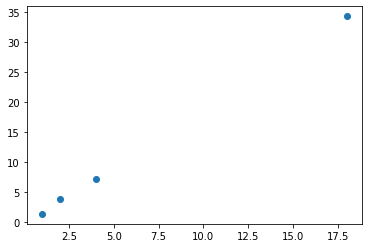

In [132]:
u = 2 * t
u *= torch.randn_like(t) / 10 + 0.95

plt.scatter(t,u);

In [133]:
prod = (t-t.mean()) * (u-u.mean()); prod

tensor([ 54.0734,  33.3165,  10.1432, 266.1020])

In [134]:
prod.mean()

tensor(90.9088)

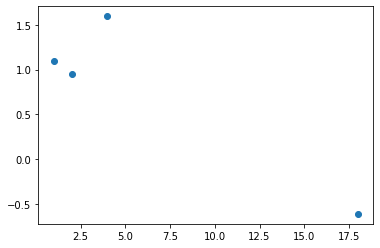

In [135]:
v = torch.randn_like(t)

plt.scatter(t,v);

In [136]:
((t-t.mean()) * (v-v.mean())).mean()

tensor(-5.1353)

In [137]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-5.1353)

In [138]:
cov / (t.std() * v.std())

tensor(-0.6797)

In [139]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()